# Evaluation Metrics

### GPU Configurations

In [1]:
import os                                        # Operating system-related functions (file, directory operations)
import sys                                       # Provides access to system-specific parameters and functions
import platform                                  # Provides functions and information about the operating system and hardware
import warnings                                  # Suppress warnings

import numpy as np                               # numerical operations & array manipulation
import pickle                                    # for object serialization & deserialization
import random                                    # generates random numbers
import math

import cv2                                       # computer vision & image processing
import tensorflow as tf                          # deep learning framework
import keras                                     # training & evaluating deep learning models

from skimage.io import imread                    # reading images
from skimage.io import imshow                    # displaying images
from tqdm import tqdm                            # creating progress bars in loops
from typing import Dict                          # type hinting
from typing import List                          # type hinting
from typing import Tuple                         # type hinting
from typing import Optional                      # type hinting
import matplotlib.pyplot as plt                  # creating plots & visualizations


import networkx as nx                            # graph-based data structures & algorithms
from skimage.morphology import skeletonize       # image skeletonization
from skimage.measure import label                # connected component labeling
from skimage.draw import line                    # drawing straight lines in images

In [2]:
# Check Operating System & Platform
print('Operating System:', platform.system(), platform.release())
print('Python Platform:', platform.platform())

# Check Python Version
print('Python Version:', sys.version)
print()

# Print library versions
print('NumPy Version:', np.__version__)
print('OpenCV Version:', cv2.__version__)
print('TensorFlow Version:', tf.__version__)
print('Keras Version:', keras.__version__)
print()

# Check if any GPU is available
print('GPU is Available:', len(tf.config.list_physical_devices('GPU')) > 0)
print('Number of GPUs Available:', len(tf.config.list_physical_devices('GPU')))

Operating System: Darwin 23.2.0
Python Platform: macOS-14.2.1-arm64-arm-64bit
Python Version: 3.11.4 (v3.11.4:d2340ef257, Jun  6 2023, 19:15:51) [Clang 13.0.0 (clang-1300.0.29.30)]

NumPy Version: 1.24.3
OpenCV Version: 4.8.0
TensorFlow Version: 2.13.0
Keras Version: 2.13.1

GPU is Available: True
Number of GPUs Available: 1


In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory limit for the first GPU to 0.31
        gpu_memory_limit = 0.30
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=int(gpu_memory_limit * 1024))]
        )
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), 'Physical GPUs,', len(logical_gpus), 'Logical GPUs')
    except RuntimeError as e:
        # Memory limit must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


2024-01-16 16:03:55.364962: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-01-16 16:03:55.364980: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-01-16 16:03:55.364985: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-01-16 16:03:55.365040: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-16 16:03:55.365070: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Access Directories

The directory containing the dataset used in this notebook is  **'../datasets/deepglobe/train'**. Create directories from the dataset's directory for the training, validation, and test data (if they do not exist). Additionally, create a directory to store pickled Numpy arrays for later usage.

In [4]:
warnings.filterwarnings('ignore')

# Directory containing dataset
dataset_dir = '../datasets/deepglobe/train'

# Directories containing 128x128 tiles of  images & masks
train_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'validation')
test_dir = os.path.join(dataset_dir, 'test')
pickel_dir = os.path.join(dataset_dir, 'pickle')

# Directories containing original 1024x1024 images & masks
orig_train_dir      = os.path.join(dataset_dir, 'original_train')
orig_validation_dir = os.path.join(dataset_dir, 'original_validation')
orig_test_dir       = os.path.join(dataset_dir, 'original_test')
orig_pickel_dir     = os.path.join(dataset_dir, 'original_pickle')

## Model Evaluation

#### Load Model

In [5]:
from keras.models import load_model

with open(os.path.join(pickel_dir, 'X_train_128.pkl'), 'rb') as f:
    X_train = pickle.load(f)

with open(os.path.join(pickel_dir, 'y_train_128.pkl'), 'rb') as f:
    y_train = pickle.load(f)

In [6]:
def calculate_iou(pred: np.ndarray, mask: np.ndarray, threshold: float = 0.5) -> float:
    '''
    Calculate Intersection over Union (IoU) for binary masks.

    Args:
        pred (np.ndarray): Predicted mask.
        mask (np.ndarray): Ground truth mask.
        threshold (float, optional): Binarization threshold. Default is 0.5.

    Returns:
        iou (float): IoU score.
    '''
    pred_bin = (pred > threshold)
    intersection = np.logical_and(mask, pred_bin)
    union = np.logical_or(mask, pred_bin)
    iou = np.sum(intersection) / np.sum(union)
    return iou


def find_best_threshold_for_iou(pred: np.ndarray, mask: np.ndarray) -> Tuple[float, float]:
    '''
    Find the best threshold that maximizes the Intersection over Union (IoU) score.

    Args:
        pred (np.ndarray): Predicted binary mask with shape (H, W, 1).
        mask (np.ndarray): Ground truth binary mask with shape (H, W, 1).

    Returns:
        best_threshold, best_iou (Tuple[float, float]): The best threshold value.
    '''
    best_threshold = 1.0
    best_iou = 0.0

    # Iterate over different threshold values
    for threshold in np.arange(1.0, 0.0, -0.01):
        iou = calculate_iou(pred, mask, threshold)
        if iou > best_iou:
            best_iou = iou
            best_threshold = threshold

    return best_threshold, best_iou

In [7]:

def create_road_network_graph(road_network: np.ndarray, distance_threshold: float = 1.5) -> nx.Graph:
    '''
    Create a road network graph from an image.

    Args:
        road_network (np.ndarray): The image representing the road network.
        distance_threshold (float): Maximum distance (in pixels) for nodes to be considered neighbors.

    Returns:
        nx.Graph: The road network graph.
    '''
    # Binarize greyscale masks to black & white, set threshold = 0.5
    road_network = (road_network > 0.5)

    # Convert to skeleton to extract centerline of roads
    skeleton = skeletonize(road_network.astype(int))
    
    # Create a NetworkX graph
    graph = nx.Graph()

    # Iterate over skeleton pixels and add them as nodes
    for r in range(0, skeleton.shape[0], 1):
        for c in range(0, skeleton.shape[1], 1):
            if skeleton[r, c] == 1 or skeleton[r, c] == True:
                graph.add_node((r, c))

    # Iterate over nodes and add edges
    for node1 in graph.nodes():
        for node2 in graph.nodes():
            if node1 != node2:
                distance = euclidean_distance(node1, node2)
                if distance <= distance_threshold:
                    graph.add_edge(node1, node2)

    return graph

def euclidean_distance(point1: Tuple[float, float], point2: Tuple[float, float]) -> float:
    '''
    Calculate Euclidean distance between two points represented as tuples (x, y).
    
    Args:
        point1 (Tuple[float, float]): 1st point as a tuple (x, y).
        point2 (Tuple[float, float]): 2nd point as a tuple (x, y).
    
    Returns:
        float: The Euclidean distance between the two points.
    '''
    node1 = np.array(point1)
    node2 = np.array(point2)
    distance = np.linalg.norm(node1 - node2)
    return distance

def contracting_nodes(graph, degree_threshold=2, min_distance=30):
    '''
    Contract nodes in a graph based on a given threshold and minimum distance.

    Args:
        graph (nx.Graph): The input graph.
        degree_threshold (float): The threshold for node contraction.
        min_distance (float): Minimum distance from a contracted node.

    Returns:
        nx.Graph: The contracted graph.
    '''
    contracted_graph = graph.copy()
    nodes_to_not_contract = []

    # Continue contracting nodes until no node has a degree greater than the threshold
    while True:
        degrees = dict(contracted_graph.degree())

        # Find nodes to contract
        nodes_to_contract = [node for node, degree in degrees.items() if degree == degree_threshold and node not in nodes_to_not_contract]

        # if all nodes are spaced min_distance apart or there is enough contraction
        if not nodes_to_contract:
            break
        
        # Contract nodes unless nodes' distance > the minimum distance
        for node in nodes_to_contract:
            neighbors = list(contracted_graph.neighbors(node))
            if len(neighbors) == 2:
                u, v = neighbors
                
                # Check the distance between contracted node and its neighbors
                if euclidean_distance(u, v) <= min_distance:
                    contracted_graph = nx.contracted_edge(contracted_graph, (u, node), self_loops=False)
                else:
                    nodes_to_not_contract.extend([node])

    return contracted_graph

def classify_road_segments(graph: nx.Graph) -> Tuple[List[Tuple[int, int]], List[Tuple[int, int]]]:
    '''
    Classify nodes in a road network graph into terminal nodes, intersection nodes, and line segments.

    Args:
        graph (nx.Graph): The road network graph.

    Returns:
        Tuple[List[Tuple[int, int]], List[Tuple[int, int]], List[List[Tuple[int, int]]]]:
            - terminal_nodes: List of terminal node coordinates (x, y).
            - intersection_nodes: List of intersection node coordinates (x, y).
    '''

    terminal_nodes = []
    intersection_nodes = []

    # Post-Processing:
    nodes_to_remove = set()  # Use a set to store nodes to remove
    edges_to_add = []        # List to store edges to add

    intermediate_nodes = set()
    nodes = list(graph.nodes())

    for node in nodes:
        neighbors = list(graph.neighbors(node))

        if len(neighbors) == 1:
            terminal_nodes.append(node)

        elif len(neighbors) > 2:
            intersection_nodes.append(node)

    return terminal_nodes, intersection_nodes

def plot_road_network_overlay(
    image, 
    graph: nx.Graph, 
    terminal_nodes: List[Tuple[int, int]], 
    intersection_nodes: List[Tuple[int, int]], 
    figsize: Tuple[int, int] = (8, 8), 
    node_size: int = 50,
    label: str = 'Road Network Graph Overlay'
) -> None:
    '''
    Plot the road network graph overlay on the provided mask image with terminal and intersection nodes highlighted.

    Args:
        image: The image to overlay the graph on.
        graph (nx.Graph): The road network graph.
        terminal_nodes (list): List of terminal node coordinates (x, y).
        intersection_nodes (list): List of intersection node coordinates (x, y).
        figsize (tuple): Figure size (width, height). Defaults to (8, 8).
        node_size (int): Node size for plotting. Defaults to 50.
        label (str):  Figure Label.
    
    Returns:
        None
    '''
    # Plot the original road mask
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')

    # Define positions for graph nodes for plotting (swapping x and y coordinates)
    pos = {node: (node[1], node[0]) for node in graph.nodes()}

    # Overlay the graph on the mask
    nx.draw(graph, pos, node_size=node_size, node_color='#FFFF00', edge_color='#FFFF00', alpha=0.9, width=5)

    # Plot terminal nodes in green and intersection nodes in red
    nx.draw_networkx_nodes(graph, pos, nodelist=terminal_nodes, node_color='red', node_size=2*node_size)
    nx.draw_networkx_nodes(graph, pos, nodelist=intersection_nodes, node_color='#39FF14', node_size=2*node_size)

    #plt.title(label=label)
    plt.show()


1/1 [==============================] - 0s 323ms/step


2024-01-16 16:04:02.675032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:04:03.089121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 618ms/step - loss: 0.0368 - io_u_1: 0.0000e+00
Loss : 0.037 IoU: 0.00


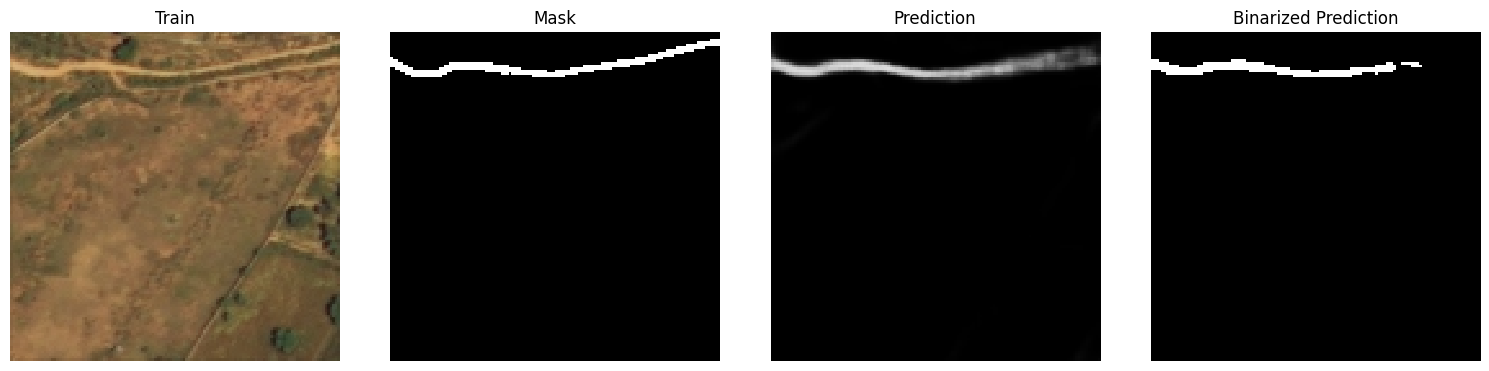

In [8]:
IMG_WIDTH = 128
IMG_HEIGHT = 128

# Set seed=?
random.seed(1)
loaded_model = load_model('unet_model_1_epoch15.h5')

datasets = [('Train', X_train, y_train)]

# Create Figure
rows = len(datasets)
columns = 4
fig = plt.figure(figsize=(15, 15))

for i, (name, images, masks) in enumerate(datasets):
    idx = random.randint(0, len(images))
    
    # Reshaping Image, change data type to float16 -> float32
    pred_image = images[idx].astype(np.float32)
    pred_image = pred_image.reshape((1, IMG_WIDTH, IMG_HEIGHT, 3))
    # Reshaping Mask
    mask_image = masks[idx]
    mask_image = mask_image.reshape((1, IMG_WIDTH, IMG_HEIGHT, 1))

    # Predict Road Segmentation
    pred = loaded_model.predict(pred_image, verbose=1)

    # Evaluate the model on the test data
    evaluation = loaded_model.evaluate(pred_image, pred, verbose=1)
    loss = evaluation[0]
    iou = evaluation[1]
    print(f'Loss : {loss:.3f}', f'IoU: {iou:.2f}')
    

    # Find Best Threshold
    best_threshold, best_iou = find_best_threshold_for_iou(pred, mask_image)
    
    # Binarise Prediction Mask
    pred_bin = (pred > 0.5)
    #print(calculate_iou(mask_image, pred_bin))

    # Loop through subplot titles and their indices
    for j, subplot_title in enumerate([name, 'Mask', 'Prediction', 'Binarized Prediction']):
        subplot_idx = j + 1 + i * columns
        subplot = fig.add_subplot(rows, columns, subplot_idx)

        if subplot_title == 'Mask':
            image = mask_image[0]
        elif subplot_title == 'Prediction':
            image = pred
        elif subplot_title == 'Binarized Prediction':
            image = pred_bin
        else:
            image = pred_image[0]
        
        imshow(np.squeeze(image), cmap='gray', ax=subplot)
        subplot.axis('off')
        subplot.set_title(subplot_title)

plt.show()

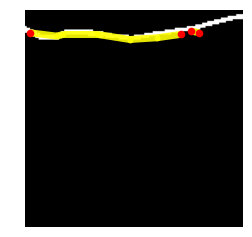

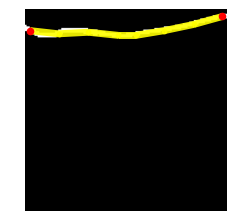

In [9]:
pred_bin2 = pred_bin.reshape((IMG_WIDTH, IMG_HEIGHT, 1))
mask_image = mask_image.reshape((IMG_WIDTH, IMG_HEIGHT, 1))

graph = create_road_network_graph(pred_bin2)
graph1 = contracting_nodes(graph, min_distance=20)

graph2 = create_road_network_graph(mask_image)
graph3 = contracting_nodes(graph2, min_distance=20)

terminal_nodes, intersection_nodes = classify_road_segments(graph)
terminal_nodes2, intersection_nodes2 = classify_road_segments(graph2)


plot_road_network_overlay(mask_image, graph1, terminal_nodes , intersection_nodes,  figsize=(3, 3), node_size=10, label='Predicted Graph on GT Mask')
plot_road_network_overlay(mask_image, graph3, terminal_nodes2, intersection_nodes2, figsize=(3, 3), node_size=10, label='Ground Truth Graph on GT Mask')

## Metrics

High Similarity: If betweenness_centrality_difference is low (close to 0), it indicates that the betweenness centralities of nodes in the proposal graph (G') are similar to those in the ground truth graph (G). This suggests that the nodes in G' are positioned in a way that paths through these nodes are similar to those in G. In this case, the two graphs are structurally similar, and the APLS similarity score for the pair of nodes is high.

Low Similarity: If betweenness_centrality_difference is high, it means that the betweenness centralities of corresponding nodes in G' are significantly different from those in G. This suggests that the structure of G' is significantly different from G in terms of how central nodes are for path traversal. In this case, the APLS similarity score for the pair of nodes is low.

In summary, the betweenness_centrality_difference serves as a structural similarity measure by quantifying how similar or different the central nodes are in the two graphs. The APLS metric uses this measure, along with other factors such as path length differences, to compute an overall similarity score that reflects how closely the structure of the proposal graph matches the ground truth graph.

1/1 [==============================] - 0s 165ms/step


2024-01-16 16:04:04.496062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:04:04.717797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 375ms/step - loss: 0.1436 - io_u_1: 0.0000e+00
Loss : 0.144 IoU: 0.00


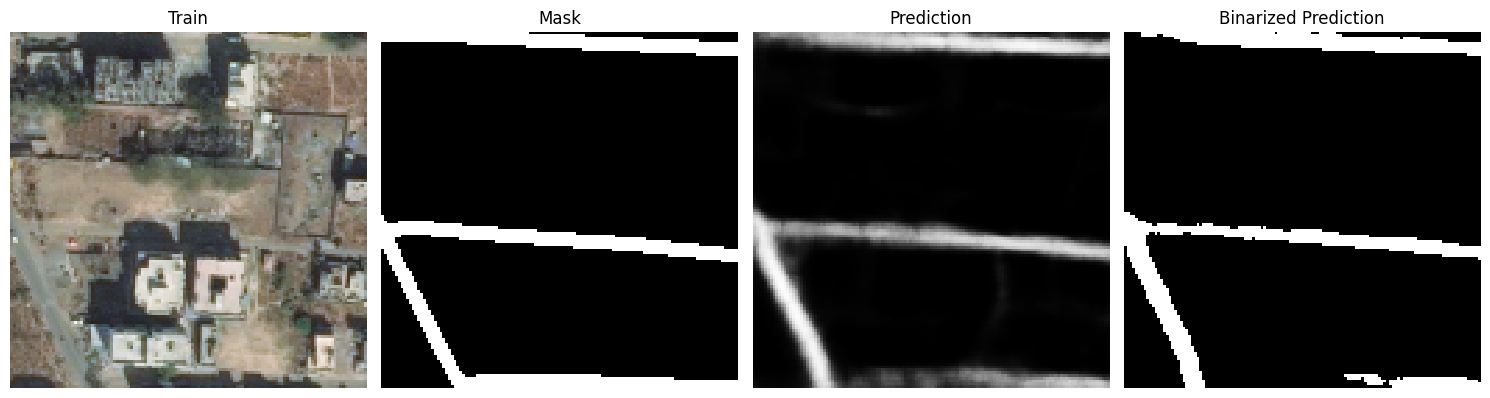

In [10]:
IMG_WIDTH = 128
IMG_HEIGHT = 128

# Set seed=11
random.seed(11) #739
loaded_model = load_model('unet_model_1_epoch15.h5')

datasets = [('Train', X_train, y_train)]

# Create Figure
rows = len(datasets)
columns = 4
fig = plt.figure(figsize=(15, 15))

for i, (name, images, masks) in enumerate(datasets):
    idx = random.randint(0, len(images))
    
    # Reshaping Image, change data type to float16 -> float32
    pred_image = images[idx].astype(np.float32)
    pred_image = pred_image.reshape((1, IMG_WIDTH, IMG_HEIGHT, 3))
    # Reshaping Mask
    mask_image = masks[idx]
    mask_image = mask_image.reshape((1, IMG_WIDTH, IMG_HEIGHT, 1))

    # Predict Road Segmentation
    pred = loaded_model.predict(pred_image, verbose=1)

    # Evaluate the model on the test data
    evaluation = loaded_model.evaluate(pred_image, pred, verbose=1)
    loss = evaluation[0]
    iou = evaluation[1]
    print(f'Loss : {loss:.3f}', f'IoU: {iou:.2f}')
    

    # Find Best Threshold
    best_threshold, best_iou = find_best_threshold_for_iou(pred, mask_image)
    
    # Binarise Prediction Mask
    pred_bin = (pred > 0.5)
    #print(calculate_iou(mask_image, pred_bin))

    # Loop through subplot titles and their indices
    for j, subplot_title in enumerate([name, 'Mask', 'Prediction', 'Binarized Prediction']):
        subplot_idx = j + 1 + i * columns
        subplot = fig.add_subplot(rows, columns, subplot_idx)

        if subplot_title == 'Mask':
            image = mask_image[0]
        elif subplot_title == 'Prediction':
            image = pred
        elif subplot_title == 'Binarized Prediction':
            image = pred_bin
        else:
            image = pred_image[0]
        
        imshow(np.squeeze(image), cmap='gray', ax=subplot)
        subplot.axis('off')
        subplot.set_title(subplot_title)

plt.tight_layout()
plt.show()

In [11]:
pred_bin2 = pred_bin.reshape((IMG_WIDTH, IMG_HEIGHT, 1))
mask_image = mask_image.reshape((IMG_WIDTH, IMG_HEIGHT, 1))

graph = create_road_network_graph(pred_bin2)
graph1 = contracting_nodes(graph, min_distance=20)

graph2 = create_road_network_graph(mask_image)
graph3 = contracting_nodes(graph2, min_distance=20)

terminal_nodes , intersection_nodes  = classify_road_segments(graph)
terminal_nodes2, intersection_nodes2 = classify_road_segments(graph2)

### Average Path Length Similarity (APLS) Metric

In [12]:
def find_nearest_node(graph: nx.Graph, point: Tuple[int, int], pixel_resolution: int = 50, max_distance: float = 10) -> Optional[int]:
    '''
    Find the nearest node in the graph to a given point.

    Args:
        graph (nx.Graph): The networkx graph.
        point (Tuple[float, float]): The coordinates of the input point (x, y).
        max_distance (float): The maximum distance to consider in metres. Defaults to positive infinity.
        pixel_resolution (int): Pixel resolution value in centimetres/pixel. Defaults to 50.

    Returns:
        Optional[float]: The nearest node in the graph, or None if no node is found within the maximum distance.
    '''
    nearest_node = None

    # Convert maximum distance to centimeters since pixel_resolution is in centimeters/pixel
    maximum_pixel_distance = max_distance * 100 / pixel_resolution
    
    for node in graph.nodes:
        pixel_distance = euclidean_distance(point, node)
        if pixel_distance < maximum_pixel_distance:
            nearest_node = node
            maximum_pixel_distance = pixel_distance
    return nearest_node

import itertools

def apls(
    ground_truth_graph: nx.Graph,
    predicted_graph: nx.Graph,
    max_difference: int = 1,
) -> float:
    '''
    Calculate the APLS metric

    Parameters:
        ground_truth_graph (nx.Graph): The ground truth graph.
        predicted_graph (nx.Graph): The predicted graph.
        max_difference (int): Maximum difference allowed in the APLS metric. Defaults to 1.
    Returns:
        float: APLS score.

    The APLS metric is calculated based on the formula:
    C = 1 - 1 / N Σ min{1, | L(a,b) - L(a',b') | / L(a,b)}

    Where:
        - N is the number of shortest paths.
        - Node a' is the node in the predicted graph nearest to node a in the ground truth graph.
        - Node b' is the node in the predicted graph nearest to node b in the ground truth graph.
        - L(a, b) denotes a path distance in the ground truth graph.
        - L(a', b') denotes the path length between corresponding nodes in the predicted graph.
        - Max difference is the maximum proportional difference between paths.
    '''

    N = 0
    total_difference = 0

     # Filter terminal nodes for the ground truth graph
    terminal_nodes, intersection_node = classify_road_segments(ground_truth_graph)
    #print(terminal_nodes)
    
    for node_a, node_b in itertools.combinations(terminal_nodes, 2):
        if node_a != node_b:
            # Find the corresponding nodes in the predicted graph a' and b'
            node_a_prime = find_nearest_node(predicted_graph, node_a)
            node_b_prime = find_nearest_node(predicted_graph, node_b)

            # Skip if no corresponding nodes ==> no proper path
            if node_a_prime is None or node_b_prime is None:
                N += 1
                total_difference += max_difference
                continue

            # Find the path length, L(a,b) in the ground truth graph
            try:
                shortest_path = nx.shortest_path(ground_truth_graph, node_a, node_b)
                L_a_b = sum(euclidean_distance(shortest_path[i], shortest_path[i+1]) for i in range(len(shortest_path) - 1))
            except (nx.NetworkXNoPath, KeyError):
                L_a_b = None

            # Find the path length, L(a',b') in the predicted graph
            try:
                shortest_path = nx.shortest_path(predicted_graph, source=node_a_prime, target=node_b_prime)
                L_a_prime_b_prime = sum(euclidean_distance(shortest_path[i], shortest_path[i+1]) for i in range(len(shortest_path) - 1))
            except (nx.NetworkXNoPath, KeyError):
                L_a_prime_b_prime = None

            # Handle the case when there are no paths
            if L_a_b is not None and L_a_prime_b_prime is not None:
                proportional_difference = abs(L_a_b - L_a_prime_b_prime) / L_a_b
                difference = min(max_difference, proportional_difference)
            elif L_a_b is None and L_a_prime_b_prime is None:
                continue
            else:
                difference = max_difference
                
            #print(L_a_b, L_a_prime_b_prime, node_a, node_b, node_a_prime, node_b_prime, difference)
            # Increment
            N += 1
            total_difference += difference

    # Calculate APLS score
    apls = 1 - total_difference / N if N > 0 else 0
    apls = round(apls, 4)

    return apls

In [14]:
similarity_score = apls(graph1, graph)
similarity_score_3_2 = apls(graph3, graph2)
similarity_score_1_3 = apls(graph1, graph3)
similarity_score_3_1 = apls(graph3, graph1)

print("Graph1-Graph0 APLS Score:", similarity_score)
print("Graph3-Graph2 APLS Score:", similarity_score_3_2)

print("Graph1-Graph3 APLS Score:", similarity_score_1_3)
print("Graph3-Graph1 APLS Score:", similarity_score_3_1)

Graph1-Graph0 APLS Score: 0.9434
Graph3-Graph2 APLS Score: 0.9647
Graph1-Graph3 APLS Score: 0.0805
Graph3-Graph1 APLS Score: 0.4831


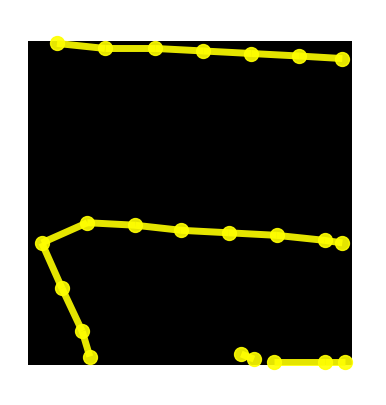

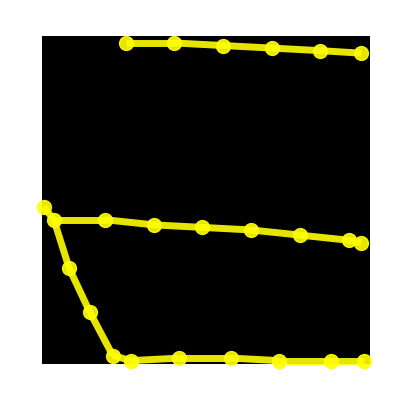

In [15]:
figsize = (5, 5)
black = np.zeros(shape=(128, 128))
plot_road_network_overlay(black, graph1, [] , [] , figsize=figsize, node_size=100)
plot_road_network_overlay(black, graph3, [], [], figsize=figsize, node_size=100)

### Topology (TOPO) Metric

In [16]:
# Point Type (coordinates)
Point = Tuple[float, float]

# Function to calculate the angle of an edge relative to the x-axis
def angle_relative_to_x_axis(edge_coords: Tuple[Point, Point]) -> float:
    '''
    Calculates the angle of an edge relative to the x-axis.

    Args:
        edge_coords (Tuple[Point, Point]): Tuple of edge coordinates.

    Returns:
        float: Angle of the edge relative to the x-axis.
    '''
    delta_x = edge_coords[1][0] - edge_coords[0][0]
    delta_y = edge_coords[1][1] - edge_coords[0][1]

    angle_radians = math.atan2(delta_y, delta_x)
    angle_degrees = math.degrees(angle_radians)
    angle_degrees_positive = angle_degrees % 360

    return round(angle_degrees_positive, 2)

# Function to check edges orientation between two graphs at specific nodes
def check_edges_orientation(graph_A: nx.Graph, graph_B: nx.Graph, node_A: int, nearest_node_B: Optional[int], min_angle: float = 10) -> bool:
    '''
    Checks the orientation of edges between two graphs at specific nodes.

    Args:
        graph_A (nx.Graph): Networkx graph as reference.
        graph_B (nx.Graph): Networkx graph for comparison.
        node_A (int): Node in graph A.
        nearest_node_B (Optional[int]): Nearest node in graph B to node_A.
        min_angle (float): Minimum acceptable angle difference. Defaults to 10.

    Returns:
        bool: True if edges' orientations are within the specified angle, False otherwise.
    '''
    edges_A = list(graph_A.edges(node_A))
    edges_B = list(graph_B.edges(nearest_node_B)) if nearest_node_B is not None else []

    if len(edges_A) == len(edges_B):
        for edge_A, edge_B in zip(edges_A, edges_B):
            angle_A = angle_relative_to_x_axis(edge_A)
            angle_B = angle_relative_to_x_axis(edge_B)

            if not abs(angle_A - angle_B) <= min_angle:
                return False
    else:
        return False

    return True

# Function to compute TOPO metric
def TOPO(ground_truth_graph: nx.Graph, predicted_graph: nx.Graph) -> Tuple[float, float, float]:
    '''
    Computes the TOPO metric, including precision, recall, and F1 score.

    Parameters:
        ground_truth_graph (Graph): The ground truth graph.
        predicted_graph (Graph): The predicted graph.

    Returns:
        Tuple[float, float, float]: Precision, recall, and F1 score.
    '''
    TP = 0 # true positives
    FP = 0 # false positives
    FN = 0 # false negatives

    # Iterating through nodes in the ground truth graph
    for node in ground_truth_graph.nodes():
        nearest_node = find_nearest_node(predicted_graph, node)

        if nearest_node is not None:
            if check_edges_orientation(ground_truth_graph, predicted_graph, node, nearest_node):
                TP += 1
            else:
                FN += 1
        else:
            FN += 1

    # Iterating through nodes in the predicted graph
    for node in predicted_graph.nodes():
        nearest_node = find_nearest_node(ground_truth_graph, node)

        if nearest_node is not None:
            if not check_edges_orientation(predicted_graph, ground_truth_graph, node, nearest_node):
                FP += 1
        else:
            FP += 1
    
    # Precision = TP / (TP + FP)
    # Recall = TP / (TP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    precision = round(precision, 4)
    recall = round(recall, 4)
    f1 = round(f1, 4)

    return precision, recall, f1


# Example usage:
precision, recall, f1 = TOPO(graph3, graph1)
print('Recall:', recall)
print('Precision:', precision)
print('F1:', f1)

precision, recall, f1 = TOPO(graph1, graph3)
print('Recall:', recall)
print('Precision:', precision)
print('F1:', f1)

Recall: 0.5833
Precision: 0.6087
F1: 0.5957
Recall: 0.6087
Precision: 0.5833
F1: 0.5957


In [17]:
graph4 = contracting_nodes(graph2, min_distance=15)

precision, recall, f1 = TOPO(graph3, graph4)
print('Recall:', recall)
print('Precision:', precision)
print('F1:', f1)

precision, recall, f1 = TOPO(graph4, graph3)
print('Recall:', recall)
print('Precision:', precision)
print('F1:', f1)

Recall: 1.0
Precision: 0.8889
F1: 0.9412
Recall: 0.9032
Precision: 1.0
F1: 0.9492
